In [1]:
import pickle
from functools import partial
import pandas as pd
import numpy as np
from scipy import optimize
from scipy.stats import spearmanr
import functions


In [2]:
#Initial 'guess' values
#Smith's flexibility used as initial weights had slightly greater
# AUC than Vihinen. So we use it as starting point in optimisation.
#Smith, David K., et al. 2003
flexibilities_smith = {'A': 0.717, 'C': 0.668, 'E': 0.963, 'D': 0.921,\
                         'G': 0.843, 'F': 0.599, 'I': 0.632, 'H': 0.754, \
                         'K': 0.912, 'M': 0.685, 'L': 0.681, 'N': 0.851,\
                         'Q': 0.849, 'P': 0.85, 'S': 0.84, 'R': 0.814, 'T': 0.758, \
                         'W': 0.626, 'V': 0.619, 'Y': 0.615}
init_state = [v for k, v in flexibilities_smith.items()]


In [3]:
with open('results/training.pkl', 'rb') as handle:
    training = pickle.load(handle)


In [4]:
with open('results/testing.pkl', 'rb') as h:
    testing = pickle.load(h)

# Bootstrap

In [6]:
bs_samples = []
for i, v in enumerate(training):
    sample = []
    for i in range(1000): #1000 resample for each training cross validation step
        sol = v.loc[v['Solubility'] == 1].sample(1000, random_state=i)
        insol = v.loc[v['Solubility'] == 0].sample(1000, random_state=i)
        sample.append(sol.append(insol))
    bs_samples.append(sample)


In [104]:
import multiprocessing
from multiprocessing import Pool





optis_full = [] #full results of optimisation
weights_full_bs = []
aucs_train_full_bs = []

for i, v in enumerate(bs_samples):
    pools = Pool(multiprocessing.cpu_count())
    optis = []
    weights = []
    aucs_train = []
    cost_funcs = [partial(functions.cost_func, df=t) for t in v]
    optimiser = partial(optimize.minimize, x0=init_state, method="Nelder-Mead", \
                             options={ 'maxiter': 3000, 'maxfev': 3000,\
                           'disp': False, 'return_all': False,\
                           'xatol': 0.001, 'fatol': 0.0001, 'adaptive': True})
    
    for result in pools.map(optimiser, cost_funcs): #map is used for correct order
        optis.append(result)
        aucs_train.append(-result['fun'])
        weights.append(result['x'])
    pools.close()
    pools.join()
    optis_full.append(optis)
    weights_full_bs.append(weights)
    aucs_train_full_bs.append(aucs_train)
    print(i)

    
cross_val_df = pd.DataFrame({'opti': optis_full, 'weights_bs':weights_full_bs, \
                             'aucs_train_bs':aucs_train_full_bs})
cross_val_df['weight'] = cross_val_df['weights'].apply(avr_arr)
aucs_train = [-functions.cost_func(cross_val_df.weight[i], t) for i, t in enumerate(training)]
aucs_test = [-functions.cost_func(cross_val_df.weight[i], t) for i, t in enumerate(testing)]
cross_val_df['aucs_train'] = aucs_train
cross_val_df['aucs_test'] = aucs_test
cross_val_df.to_pickle('results/cross_validation.pkl.gz', compression='infer')

In [105]:
cross_val_df.head(2)

,opti,weights,aucs_train,weight,aucs_test
0,"[{'fun': -0.7180199999999999, 'nit': 608, 'nfe...","[[0.8322705993979348, 0.44725839962689096, 0.9...",0.722218,"[0.8401057564601928, 0.5129126694002384, 0.989...",0.685278
1,"[{'fun': -0.74127, 'nit': 518, 'nfev': 1558, '...","[[0.8006190763377172, 0.5452312429219268, 0.98...",0.717487,"[0.8298966146942772, 0.5158415589287934, 0.989...",0.723142


In [ ]:
cross_val_df.to_pickle('results/cross_validation.pkl.gz', compression='infer')

In [3]:
cross_val_df = pd.read_pickle('results/cross_validation.pkl.gz')

In [7]:
mean_std = pd.DataFrame(index=['Training', 'Test'])
mean_std.loc['Training', 'Mean'] = np.mean(cross_val_df['aucs_train'])
mean_std.loc['Training', 'Std'] = np.std(cross_val_df['aucs_train'])
mean_std.loc['Test', 'Mean'] = np.mean(cross_val_df['aucs_test'])
mean_std.loc['Test', 'Std'] = np.std(cross_val_df['aucs_test'])
mean_std

,Mean,Std
Training,0.718748,0.003490
Test,0.710514,0.030961


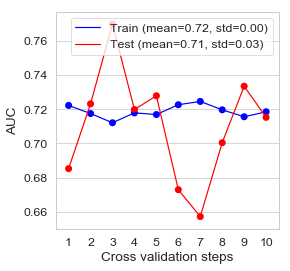

In [33]:
functions.plt.figure(figsize=(4, 4))
functions.sns.pointplot(list(range(10)), cross_val_df['aucs_train'], label='Train (mean=0.72, std=0.00)',\
                       linestyles=[' '], markers=['o'], color='blue')
functions.sns.lineplot(list(range(10)), cross_val_df['aucs_train'], label='Train (mean=0.72, std=0.00)',\
                       color='blue')
functions.sns.pointplot(list(range(10)), cross_val_df['aucs_test'],  label='Test (mean=0.71, std=0.03)',\
                        linestyles=[''], markers=['o'], color='red')
ax = functions.sns.lineplot(list(range(10)), cross_val_df['aucs_test'],  label='Test (mean=0.71, std=0.03)',\
                        color='red')
functions.plt.ylabel('AUC')
functions.plt.xlabel('Cross validation steps')

ax.set_xticklabels(list(range(1,11)))
functions.plt.savefig('figs/cross_validation_test_train.pdf')
# 

In [5]:
SWI_cv = pd.DataFrame(cross_val_df['weight'].values.tolist(), columns=[k for k,v in flexibilities_smith.items()])
SWI_cv.mean()#.sort_values()

A    0.835696
C    0.521921
E    0.986866
D    0.907598
G    0.800383
F    0.582193
I    0.679045
H    0.896398
K    0.925917
M    0.629996
L    0.654692
N    0.860496
Q    0.789565
P    0.822104
S    0.744246
R    0.771055
T    0.809867
W    0.638693
V    0.734495
Y    0.612558
dtype: float64

### Plot weights (initial and final) with hydrophobicity

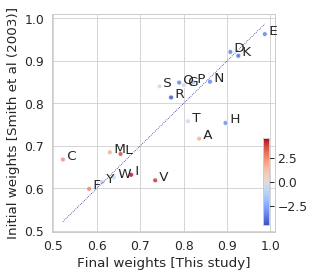

In [6]:

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#using hydrophobicity as hue# Kyte & Doolittle index of hydrophobicity
# J. Mol. Biol. 157:105-132(1982).
kd = {"A": 1.8, "R": -4.5, "N": -3.5, "D": -3.5, "C": 2.5,
      "Q": -3.5, "E": -3.5, "G": -0.4, "H": -3.2, "I": 4.5,
      "L": 3.8, "K": -3.9, "M": 1.9, "F": 2.8, "P": -1.6,
      "S": -0.8, "T": -0.7, "W": -0.9, "Y": -1.3, "V": 4.2}

df1 = pd.DataFrame(columns=SWI_cv.mean().index, \
                   index=['Initial weights [Smith et al. (2003)]', 'Final weights [This study]'])
df1.loc['Initial weights [Smith et al (2003)]'] = [v for k,v in flexibilities_smith.items()]
df1.loc['Final weights [This study]'] = SWI_cv.mean().values
df1 = df1.transpose()
for k, v in kd.items():
    df1.loc[k, 'Hydrophobicity'] = v
df1.reset_index(inplace=True)

functions.sns.set(style="whitegrid")
functions.sns.set_context("paper", font_scale=1.4)
functions.plt.figure(figsize=(4, 4))

# cmap = functions.sns.cubehelix_palette(8, start=.5, rot=-.75, as_cmap=True).reversed()#for colorbar

norm = functions.plt.Normalize(df1['Hydrophobicity'].min(), df1['Hydrophobicity'].max())
sm = functions.plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])


y = 'Initial weights [Smith et al (2003)]'
x = 'Final weights [This study]'
g = functions.sns.scatterplot(x, y, data=df1, markers=False, hue=df1['Hydrophobicity'], \
                              palette="coolwarm", \
                             alpha=.8,  ) #relplot, height=6
functions.plt.plot([SWI_cv.mean().min(), SWI_cv.mean().max()], \
                   [SWI_cv.mean().min(), SWI_cv.mean().max()], color='navy', lw=.75, linestyle=':')
# functions.sns.despine()#color bar
g.get_legend().remove()
cbaxes = inset_axes(g, width="3%", height="40%", loc=4)
cb = g.figure.colorbar(sm, cax=cbaxes, orientation="vertical")

for i, v in enumerate(df1['index']):
    g.annotate(' ' +v, [df1[x][i], df1[y][i]])
functions.plt.savefig('figs/weight_scatterplot.pdf')

Text(0.5, 0, 'Amino acids')

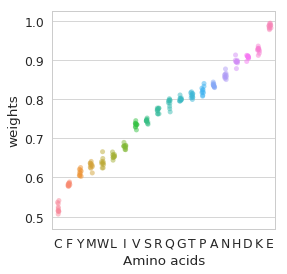

In [7]:
#weight_df
cols = [k for k, v in flexibilities_smith.items()]
wdf = pd.DataFrame(columns=cols, index=list(range(10)))
weights = cross_val_df['weight'].values #weights from CV

for idx, val in enumerate(weights):
    for i, v in enumerate(val):
        wdf.loc[idx][cols[i]] = v

        
dd = pd.melt(wdf)
dd['value'] = dd['value'].astype(float)
dd.sort_values(ascending=True, by='value', inplace=True)


# functions.sns.set(style="white")
functions.plt.figure(figsize=(4, 4))

ax = functions.sns.stripplot(x="variable", y="value", data=dd, alpha=0.5, s=5)
functions.plt.ylabel('weights')
functions.plt.xlabel('Amino acids')
# functions.sns.despine()
# functions.plt.savefig('figs/cross_validation_weights_test.pdf')


In [31]:
# cross_val_df.to_csv('results/cross_validation_results.csv', index=None)

In [8]:
new_wts = {} #This is for SWI

for i, c in enumerate(wdf.columns):
    new_wts[c] = np.mean(wdf[c])
new_wts

{'A': 0.8356956599678218,
 'C': 0.5219207324456876,
 'E': 0.9868660417547442,
 'D': 0.9075983546378998,
 'G': 0.8003827946673535,
 'F': 0.5821934635876957,
 'I': 0.6790449304566072,
 'H': 0.8963977585570367,
 'K': 0.9259165090012061,
 'M': 0.6299964100098959,
 'L': 0.6546922237065839,
 'N': 0.8604957042204235,
 'Q': 0.7895650031998229,
 'P': 0.822104415564934,
 'S': 0.7442464390120463,
 'R': 0.771055152304471,
 'T': 0.8098670971949234,
 'W': 0.6386931894494416,
 'V': 0.7344952876686051,
 'Y': 0.6125581495225544}

## For eSOL using SWI

In [34]:

#For ecoli data

#using SWI
ecoli_w3110 = pd.read_pickle('results/ecoli.pkl.gz', compression='infer')

ecoli_w3110['f'] = ecoli_w3110['Sequence'].apply(lambda x:functions.solubility_score(x, new_wts))
ecoli_w3110['Average_Score'] = ecoli_w3110['f'].apply(lambda x:np.mean(x))



from scipy.stats import spearmanr

spearmanr(ecoli_w3110['Average_Score'], ecoli_w3110['Solubility(%)'])

SpearmanrResult(correlation=0.5040987724767835, pvalue=9.458243956892371e-206)

## For eSOL using initial weights

In [9]:

#For ecoli data

#using b-factors from Smith et al.
ecoli_w3110 = pd.read_pickle('results/ecoli.pkl.gz', compression='infer')

ecoli_w3110['f'] = ecoli_w3110['Sequence'].apply(lambda x:functions.solubility_score(x, flexibilities_smith))
ecoli_w3110['Average_Score'] = ecoli_w3110['f'].apply(lambda x:np.mean(x))



from scipy.stats import spearmanr

spearmanr(ecoli_w3110['Average_Score'], ecoli_w3110['Solubility(%)'])

SpearmanrResult(correlation=0.39525618255208833, pvalue=4.572683656231933e-120)

In [11]:
ecoli_w3110.shape

(3198, 7)